<a href="https://colab.research.google.com/github/IrmaVeoll/pytorch_notebooks/blob/master/mnist_es/pytorch_mnist_mini_es_rank_oes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import math
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from PIL import Image
import os
import os.path
import errno
import codecs
import copy

In [50]:
torch.manual_seed(0)
np.random.seed(0)
print("torch.cuda.device_count()", torch.cuda.device_count())
print("torch.cuda.current_device()", torch.cuda.current_device())
torch.cuda.set_device(0)
print("torch.cuda.current_device()", torch.cuda.current_device())

torch.cuda.device_count() 1
torch.cuda.current_device() 0
torch.cuda.current_device() 0


In [51]:
def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255):          # population size

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.popsize = popsize

    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize})

  def rms_stdev(self):
    sigma = self.es.result()[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = reward_table_result
    self.es.tell(self.solutions, (-reward_table).tolist()) # convert minimizer to maximizer.

  def done(self):
    return self.es.stop()

  def current_param(self):
    return self.es.result()[5] # mean solution, presumably better with noise
  
  def best_param(self):
    return self.es.result()[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result()
    return (r[0], -r[1], -r[1], r[6])

class SimpleES:
  '''Simple Evolution Strategies.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               sigma_alpha=0.20,      # learning rate for standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               done_threshold=1e-6,   # threshold when we say we are done
               average_baseline=True, # set baseline to average of batch
               forget_best=True):     # only use the best from latest generation

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize & 2), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)
    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)
    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.done_threshold = done_threshold

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = reward_table_result

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # adaptive sigma
    # normalization
    stdev_reward = reward.std()
    epsilon = self.epsilon
    sigma = self.sigma
    S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
    reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
    rS = reward_avg - b
    delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

    # move mean to the average of the best idx means
    self.mu += self.epsilon_full[idx].mean(axis=0)

    # adjust sigma according to the adaptive sigma calculation
    change_sigma = self.sigma_alpha * delta_sigma
    change_sigma = np.minimum(change_sigma, self.sigma)
    change_sigma = np.maximum(change_sigma, - 0.5 * self.sigma)
    self.sigma += change_sigma
    self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.curr_best_mu
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

class SimpleGA:
  '''Simple Genetic Algorithm.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=True,      # forget the historical best elites
               done_threshold=1e-6):  # threshold when we say we are done

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize

    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)

    self.sigma = self.sigma_init
    self.elite_params = np.zeros((self.elite_popsize, self.num_params))
    self.elite_rewards = np.zeros(self.elite_popsize)
    self.best_param = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_iteration = True
    self.forget_best = forget_best
    self.done_threshold = done_threshold

  def rms_stdev(self):
    return self.sigma # same sigma for all parameters.

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
    solutions = []
    
    def mate(a, b):
      c = np.copy(a)
      idx = np.where(np.random.rand((c.size)) > 0.5)
      c[idx] = b[idx]
      return c
    
    elite_range = range(self.elite_popsize)
    for i in range(self.popsize):
      idx_a = np.random.choice(elite_range)
      idx_b = np.random.choice(elite_range)
      child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
      solutions.append(child_params + self.epsilon[i])

    solutions = np.array(solutions)
    self.solutions = solutions

    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."
    
    if (not forget_best or self.first_iteration):
      reward = reward_table_result
      solution = self.solutions
    else:
      reward = np.concatenate([reward_table_result, self.elite_rewards])
      solution = np.concatenate([self.solutions, self.elite_params])

    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    self.elite_rewards = reward[idx]
    self.elite_params = solution[idx]

    self.curr_best_reward = self.elite_rewards[0]
    
    if self.first_iteration or (self.curr_best_reward > self.best_reward):
      self.first_iteration = False
      self.best_reward = self.elite_rewards[0]
      self.best_param = np.copy(self.elite_params[0])

    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.elite_params[0]

  def best_param(self):
    return self.best_param

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)

class OpenES:
  ''' Basic Version of OpenAI Evolution Strategies.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.1,               # initial standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               learning_rate=0.001,          # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.001,  # stop annealing learning rate
               popsize=255,                  # population size
               antithetic=False,             # whether to use antithetic sampling
               forget_best=True):           # forget historical best

    self.num_params = num_params
    self.sigma_decay = sigma_decay
    self.sigma = sigma_init
    self.sigma_limit = sigma_limit
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.antithetic = antithetic
    if self.antithetic:
      assert (self.popsize & 2), "Population size must be even"
      self.half_popsize = int(self.popsize / 2)

    self.reward = np.zeros(self.popsize)
    self.mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.forget_best = forget_best

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    if self.antithetic:
      self.epsilon_half = np.random.randn(self.half_popsize, self.num_params)
      self.epsilon = np.concatenate([self.epsilon_half, - self.epsilon_half])
    else:
      self.epsilon = np.random.randn(self.popsize, self.num_params)
    self.epsilon *= np.random.choice([0, 1], size=self.epsilon.shape, p=[0.95, 0.05])
    self.solutions = self.mu.reshape(1, self.num_params) + self.epsilon * self.sigma

    return self.solutions

  def tell(self, reward):
    # input must be a numpy float array
    assert(len(reward) == self.popsize), "Inconsistent reward_table size reported."

    idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    best_mu = self.solutions[idx[0]]

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # main bit:
    # standardize the rewards to have a gaussian distribution
    normalized_reward = (reward - np.mean(reward)) / np.std(reward)
    self.mu += self.learning_rate/(self.popsize*self.sigma)*np.dot(self.epsilon.T, normalized_reward)

    # adjust sigma according to the adaptive sigma calculation
    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

    if (self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def done(self):
    return False

  def current_param(self):
    return self.curr_best_mu

  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

In [52]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])

In [53]:
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)

In [54]:
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

In [55]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

In [56]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_filter1 = 8
    self.num_filter2 = 16
    self.num_padding = 2
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, self.num_filter1, 5, padding=self.num_padding)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(self.num_filter1, self.num_filter2, 5, padding=self.num_padding)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(self.num_filter2*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_filter2*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x, -1)

In [57]:
NPOPULATION = 101
weight_decay_coef = 0.1

In [58]:
'''
models = []
for i in range(NPOPULATION):
  model = Net()
  if args.cuda:
    model.cuda()
  model.eval()
  models.append(model)
'''

model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

In [59]:
# get init params
orig_params = []
model_shapes = []
for param in orig_model.parameters():
  p = param.data.cpu().numpy()
  model_shapes.append(p.shape)
  orig_params.append(p.flatten())
orig_params_flat = np.concatenate(orig_params)
NPARAMS = len(orig_params_flat)
print(NPARAMS)

11274


In [60]:
def update_model(flat_param, model, model_shapes):
  idx = 0
  i = 0
  for param in model.parameters():
    delta = np.product(model_shapes[i])
    block = flat_param[idx:idx+delta]
    block = np.reshape(block, model_shapes[i])
    i += 1
    idx += delta
    block_data = torch.from_numpy(block).float()
    if args.cuda:
      block_data = block_data.cuda()
    param.data = block_data

In [61]:
def evaluate(model, test_loader, print_mode=True, return_loss=False):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    with torch.no_grad():
      output = model(data)
    test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct.item() / len(test_loader.dataset)
  
  if print_mode:
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * acc))
  
  if return_loss:
    return test_loss
  return acc

In [62]:
"""
es = SimpleES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_alpha=0.2,
              sigma_limit=0.001,
              elite_ratio=0.1,
              average_baseline=False,
              forget_best=True
             )
"""
es = OpenES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_limit=0.01,
              forget_best=False,
              learning_rate=0.001,
              learning_rate_decay = 0.9999,
              learning_rate_limit = 0.0001,
             )

In [63]:
def worker(procnum, model, solution, data, target, send_end):
  update_model(solution, model, model_shapes)
  output = model(data)
  loss = F.nll_loss(output, target)
  reward = - loss.data[0]
  send_end.send(reward)

def batch_simulation(model_list, solutions, data, target, process_count):
  jobs = []
  pipe_list = []

  for i in range(process_count):
    recv_end, send_end = mp.Pipe(False)
    p = mp.Process(target=worker, args=(i, model_list[i], solutions[i], data, target, send_end))
    jobs.append(p)
    pipe_list.append(recv_end)

  for p in jobs:
    p.start()

  for p in jobs:
    p.join()

  result_list = [x.recv() for x in pipe_list]
  return np.array(result_list)


def batch_simulation_sequential(model_list, solutions, data, target, process_count):
  result_list = []
  for i in range(process_count):
    update_model(solutions[i], model_list[i], model_shapes)
    output = model_list[i](data)
    loss = F.nll_loss(output, target)
    reward = - loss.data[0]
    result_list.append(reward)
  return np.array(result_list)


In [64]:
#'''
best_valid_acc = 0
training_log = []
for epoch in range(1, 10*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.item()

    best_raw_reward = reward.max()
    #reward = compute_centered_ranks(reward)
    l2_decay = compute_weight_decay(weight_decay_coef, solutions)
    reward += l2_decay

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 5 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), result[3])

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)
#'''

1 0 -2.3023624420166016 1.0898497362227534e-05 0.01
1 5 -2.301177978515625 2.834081430649074e-05 0.01
1 10 -2.303084373474121 -2.799282668709923e-05 0.01
1 15 -2.29905104637146 8.075514556981824e-05 0.01
1 20 -2.2880311012268066 0.00027404025478813246 0.01
1 25 -2.258342742919922 0.000440729248383675 0.01
1 30 -2.2133383750915527 0.0005939126582257041 0.01
1 35 -2.1373579502105713 0.0007310153958445655 0.01
1 40 -2.032421350479126 0.0009558262538970033 0.01
1 45 -1.8990867137908936 0.0011749661408430696 0.01
1 50 -1.7393735647201538 0.001377083806737463 0.01
1 55 -1.5690048933029175 0.0015661080165519274 0.01
valid_acc 67.4
best valid_acc 67.4
2 0 -1.3771964311599731 0.0017438036417620293 0.01
2 5 -1.2249431610107422 0.0019392346889807624 0.01
2 10 -1.1322171688079834 0.002028226264843645 0.01
2 15 -0.9609331488609314 0.002171132888185924 0.01
2 20 -0.8956589698791504 0.002275266376969368 0.01
2 25 -0.7936075925827026 0.002317368423264199 0.01
2 30 -0.7702688574790955 0.002381031128419

In [65]:
evaluate(best_model, valid_loader, print_mode=True)


Average loss: 0.0296, Accuracy: 59485/60000 (99.1417%)



0.9914166666666666

In [66]:
evaluate(best_model, test_loader, print_mode=True)


Average loss: 0.0475, Accuracy: 9856/10000 (98.5600%)



0.9856

In [67]:
evaluate(best_model, train_loader, print_mode=True)


Average loss: 0.0296, Accuracy: 59485/60000 (99.1417%)



0.9914166666666666

In [68]:
update_model(es.best_param(), model, model_shapes)

In [69]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0303, Accuracy: 59455/60000 (99.0917%)



0.9909166666666667

In [70]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0465, Accuracy: 9855/10000 (98.5500%)



0.9855

In [71]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0303, Accuracy: 59455/60000 (99.0917%)



0.9909166666666667

In [72]:
update_model(es.current_param(), model, model_shapes)

In [73]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0296, Accuracy: 59485/60000 (99.1417%)



0.9914166666666666

In [74]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0475, Accuracy: 9856/10000 (98.5600%)



0.9856

In [75]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0296, Accuracy: 59485/60000 (99.1417%)



0.9914166666666666

In [76]:
eval_acc = evaluate(best_model, test_loader)
print('final test acc', eval_acc * 100.)


Average loss: 0.0475, Accuracy: 9856/10000 (98.5600%)

final test acc 98.56


In [77]:
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([10, 784])
torch.Size([10])
11274


In [78]:
orig_params = []
for param in orig_model.parameters():
  orig_params.append(param.data.cpu().numpy().flatten())

In [79]:
orig_params_flat = np.concatenate(orig_params)

In [80]:
import matplotlib.pyplot as plt

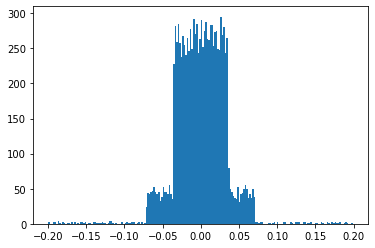

In [81]:
_ = plt.hist(orig_params_flat, bins=200)
plt.show()

In [82]:
final_params = []
for param in best_model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)

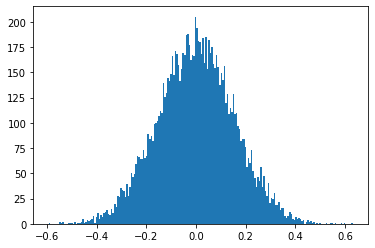

In [83]:
_ = plt.hist(final_params_flat, bins=200)
plt.show()